In [1]:
# -*- coding: utf-8 -*-
import re
from pathlib import Path
import pandas as pd
import numpy as np
import math

# --------------- config ---------------
INPUT_XLSX = "Project.xlsx"
OUTPUT_DIR = Path("output_datasets")
OUTPUT_DIR.mkdir(exist_ok=True)

EXCLUDE_CODES = {"4174", "4152", "4153", "38914"}


In [2]:
# --------------- helpers ---------------
def _parse_date(s):
    """Parse dates as day-first (matches screenshots)."""
    return pd.to_datetime(s, dayfirst=True, errors="coerce")

def _norm_cols(df):
    """Trim and collapse whitespace in headers."""
    df = df.copy()
    df.columns = (
        pd.Index(df.columns)
        .map(lambda c: "" if pd.isna(c) else str(c))
        .map(lambda c: c.strip())
        .map(lambda c: re.sub(r"\s+", " ", c))
    )
    return df

def _pick_column_for_code(code, mapping_dict):
    """Return best matching column for a portfolio code from a dict {code: colname}."""
    if code in mapping_dict:
        return mapping_dict[code]
    # Fallback: trailing/leading digit overlaps
    for k, v in mapping_dict.items():
        if not k:
            continue
        if code.endswith(k) or k.endswith(code):
            return v
    return None

def _require_columns(df, needed, context):
    """Raise early if required columns are missing."""
    missing = [c for c in needed if c not in df.columns]
    if missing:
        raise ValueError(f"[{context}] Missing expected columns: {missing}")

def ensure_date_column(df, preferred=("Date", "Dates", "Row Labels")):
    """
    Guarantee a 'Date' column:
      1) Try common labels (case-insensitive).
      2) Else promote the first column to 'Date'.
    Then parse dates day-first.
    """
    df = df.copy()
    df.columns = [("" if pd.isna(c) else str(c)).strip() for c in df.columns]
    lower = {c.lower(): c for c in df.columns}
    for p in preferred:
        p_l = p.lower()
        if p_l in lower:
            if lower[p_l] != "Date":
                df = df.rename(columns={lower[p_l]: "Date"})
            break
    else:
        first_col = df.columns[0]
        if first_col != "Date":
            df = df.rename(columns={first_col: "Date"})
    df["Date"] = _parse_date(df["Date"])
    return df

# ---------- Curve helpers (kept; not used after the change) ----------
def find_20y_column(curve_df):
    """
    Find the 20Y tenor column:
      - Prefer exact numeric header '20' / '20.0'.
      - Fallback to textual variants (20YR / 20 YEAR / 20Y).
    """
    for c in curve_df.columns:
        try:
            if abs(float(str(c).strip()) - 20.0) < 1e-12:
                return c
        except Exception:
            continue
    rx_list = [r"^\s*20\s*$", r"^\s*20\.0+\s*$", r".*\b20\s*YR\b.*", r".*\b20\s*YEAR\b.*", r".*\b20Y\b.*"]
    for c in curve_df.columns:
        if any(re.search(rx, str(c), flags=re.IGNORECASE) for rx in rx_list):
            return c
    raise ValueError("[Curve] Could not locate a 20-year tenor column (header like 20 / 20.0).")

def find_spread_col(curve_df, which="A"):
    """
    Find Spread A / Spread BBB columns. Accepts 'A'/'BBB' or 'Spread A'/'Spread BBB'.
    """
    patterns = {
        "A":   [r"^\s*A\s*$", r".*\bSpread\s*A\b.*"],
        "BBB": [r"^\s*BBB\s*$", r".*\bSpread\s*B{3}\b.*"],
    }[which]
    matches = []
    for c in curve_df.columns:
        if any(re.search(rx, str(c), flags=re.IGNORECASE) for rx in patterns):
            matches.append(c)
    if not matches:
        raise ValueError(f"[Curve] Could not find a column for Spread {which} (try 'A' or 'Spread A').")
    return max(matches, key=lambda s: len(str(s)))  # prefer most explicit header
    

In [3]:
# --------------- load all sheets ---------------
with pd.ExcelFile(INPUT_XLSX) as xls:
    portfolios = pd.read_excel(xls, sheet_name="Portfolios")
    peergroups = pd.read_excel(xls, sheet_name="PeerGroups")
    mapping    = pd.read_excel(xls, sheet_name="Portfolio_peerGroup_mapping")
    # Two-row header: row 1 = metric (Muni_OAD/Muni_DTS/YTW), row 2 = code+suffix (e.g., 4316POSONLY)
    oad_dts    = pd.read_excel(xls, sheet_name="OAD_DTS_YTW", header=[0, 1])
    # curve      = pd.read_excel(xls, sheet_name="Curve")
    curve      = pd.read_excel(xls, sheet_name="Curve", header=[0, 1])
    housing    = pd.read_excel(xls, sheet_name="Housing_spreads")


In [4]:
# ---- Holidays: read once and build a normalized date set ----
def _read_holidays(path="Input_file.xlsx", sheet="Holidays"):
    df = pd.read_excel(path, sheet_name=sheet)
    # normalize headers a bit
    df.columns = [("" if pd.isna(c) else str(c)).strip() for c in df.columns]
    # find the 'Date' column case-insensitively
    lower = {c.lower(): c for c in df.columns}
    if "date" not in lower:
        raise ValueError("[Holidays] Could not find a 'Date' column in the Holidays sheet.")
    dcol = lower["date"]
    # parse as day-first; normalize to midnight
    d = pd.to_datetime(df[dcol], dayfirst=True, errors="coerce").dropna().dt.normalize()
    return set(d.unique())

HOLIDAYS = _read_holidays("Input_file.xlsx", "Holidays")
len(HOLIDAYS), list(sorted(HOLIDAYS))[:5]  # quick sanity peek


(35,
 [Timestamp('2023-01-02 00:00:00'),
  Timestamp('2023-01-16 00:00:00'),
  Timestamp('2023-02-20 00:00:00'),
  Timestamp('2023-04-07 00:00:00'),
  Timestamp('2023-05-29 00:00:00')])

In [5]:
def _drop_holidays(df, date_col="Date"):
    """
    Return df with rows removed where Date (normalized) is in HOLIDAYS.
    Safe if column is not present.
    """
    if date_col not in df.columns:
        return df
    out = df.copy()
    # parse/normalize without changing your original dtype flow
    tmp = pd.to_datetime(out[date_col], dayfirst=True, errors="coerce").dt.normalize()
    mask = ~tmp.isin(HOLIDAYS)
    return out.loc[mask].reset_index(drop=True)


In [6]:
portfolios = _drop_holidays(portfolios, "Date")
peergroups = _drop_holidays(peergroups, "Date")
oad_dts    = _drop_holidays(oad_dts,    "Date")
curve      = _drop_holidays(curve,      "Date")
housing    = _drop_holidays(housing,    "Date")


In [7]:

# --------------- normalize & prune ---------------
portfolios = _norm_cols(portfolios)
peergroups = _norm_cols(peergroups)
mapping    = _norm_cols(mapping)
# oad_dts    = _norm_cols(oad_dts)
# curve      = _norm_cols(curve)
housing    = _norm_cols(housing)


In [8]:
portfolios
peergroups
mapping
oad_dts
curve
housing
mapping


,Portfolio_code,Morningstar_name,PeerGroup_name
0,4316,Franklin Federal Tax Free Income Adv,US OE Muni National Long
1,26176,Franklin Municipal Green Bond ETF,US OE Muni National Long
2,4174,Franklin Federal Interm-Term T/F Inc Adv,US OE Muni National Interm
3,4363,Franklin VA Tax Free Income Adv,US OE Muni Single State Long
4,4360,Franklin MO Tax Free Income Adv,US OE Muni Single State Long
5,4319,Franklin MI Tax-Free Inc Adv,US OE Muni Single State Long
6,4364,Franklin Alabama Tax Free Income Advisor,US OE Muni Single State Long
7,4328,Franklin Georgia Tax Free Income Advisor,US OE Muni Single State Long
8,4327,Franklin CO Tax Free Income Adv,US OE Muni Single State Long
9,4370,Franklin NC Tax-Free Income Adv,US OE Muni Single State Long


In [9]:
# Parse dates & keys
portfolios["Date"] = _parse_date(portfolios["Date"])
peergroups["Date"] = _parse_date(peergroups["Date"])
mapping["Portfolio_code"] = mapping["Portfolio_code"].astype(str).str.strip()

# ---------- Standardize Date on Curve & Housing ----------
# curve   = ensure_date_column(curve,   preferred=("Date", "Dates"))
housing = ensure_date_column(housing, preferred=("Date", "Row Labels"))

# ---------- Filter 1D returns ----------
port_ret_1d = (
    portfolios
    .loc[portfolios["Period"].astype(str).str.upper().eq("1D"), ["Date", "Portfolio", "Return"]]
    .rename(columns={"Return": "Portfolio_Return_1D"})
    .dropna(subset=["Date"])
)
pg_ret_1d = (
    peergroups
    .loc[peergroups["Period"].astype(str).str.upper().eq("1D"), ["Date", "Portfolio", "Median_Return"]]
    .rename(columns={"Portfolio": "PeerGroup_name", "Median_Return": "PeerGroup_Return_1D"})
    .dropna(subset=["Date"])
)

# ---------- Housing spreads ----------
housing_cols_map = {
    "Multi-Family Private": "MF_Private_Spread",
    "Multi-Family Workforce": "MF_Workforce_Spread",
}
# tolerate small whitespace/case variations
for k in list(housing_cols_map.keys()):
    if k not in housing.columns:
        for c in housing.columns:
            if re.fullmatch(re.sub(r"\s+", r"\\s*", k), c, flags=re.IGNORECASE):
                housing_cols_map[c] = housing_cols_map.pop(k)
                break
housing_sel = ["Date"] + list(housing_cols_map.keys())
_require_columns(housing, housing_sel, "Housing_spreads")
housing_spreads = housing[housing_sel].rename(columns=housing_cols_map).dropna(subset=["Date"])


In [10]:

# ---------- Curve (two-row header): pick 20Y + Spread A/BBB from second header row ----------
def _clean(x):
    return "" if pd.isna(x) else str(x).strip()

# Ensure MultiIndex columns are clean strings
if not isinstance(curve.columns, pd.MultiIndex):
    curve.columns = pd.MultiIndex.from_tuples([(_clean(c), "") for c in curve.columns])
else:
    curve.columns = pd.MultiIndex.from_tuples([(_clean(a), _clean(b)) for a, b in curve.columns])

# Detect the Date column by content (either level may say 'Dates')
def _score_as_date_col(series, sample_n=200):
    s = pd.Series(series).dropna().astype(str)
    if sample_n and len(s) > sample_n:
        s = s.iloc[:sample_n]
    parsed = pd.to_datetime(s, dayfirst=True, errors="coerce")
    return 0.0 if len(s) == 0 else float(parsed.notna().mean())

candidates = []
for col in list(curve.columns):
    score = _score_as_date_col(curve[col])
    a, b = col
    if _clean(a).lower() in {"date","dates"} or _clean(b).lower() in {"date","dates"}:
        score += 0.5
    candidates.append((score, col))
candidates.sort(key=lambda x: x[0], reverse=True)
best_score, best_col = candidates[0]
if best_score < 0.25:
    best_col = curve.columns[0]

# Extract Date by position and flatten headers
date_idx = list(curve.columns).index(best_col)
curve_date = _parse_date(curve.iloc[:, date_idx])
curve_flat = curve.copy()
curve_flat.columns = [f"{_clean(a)}::{_clean(b)}" for (a, b) in curve.columns]
curve_flat.insert(0, "Date", curve_date)

curve_flat = _drop_holidays(curve_flat, "Date")

# Helper to find the 20Y tenor column from level-0 (numeric 20), else fallback to names
def _find_20y_column_from_mi(mi_cols):
    # Prefer exact numeric tenor in level-0
    for a, b in mi_cols:
        try:
            if abs(float(a) - 20.0) < 1e-12:
                return f"{_clean(a)}::{_clean(b)}"
        except Exception:
            pass
    # Fallback: textual variants in either level
    rx = re.compile(r"(?:^|\b)20\s*(?:YR|YEAR|Y)?\b", flags=re.IGNORECASE)
    for a, b in mi_cols:
        if rx.search(_clean(a)) or rx.search(_clean(b)):
            return f"{_clean(a)}::{_clean(b)}"
    raise ValueError("[Curve] Could not locate 20Y tenor column.")

# Find Spread A/BBB explicitly from the *second* header row (level-1)
def _find_spread_from_second_header(mi_cols, target):
    # target is 'Spread A' or 'Spread BBB' (case-insensitive, trim spaces)
    for a, b in mi_cols:
        if _clean(b).lower() == target.lower():
            return f"{_clean(a)}::{_clean(b)}"
    # light fallback: also accept exact 'A'/'BBB' in second header
    short = "A" if target.endswith("A") else "BBB"
    for a, b in mi_cols:
        if _clean(b).upper() == short:
            return f"{_clean(a)}::{_clean(b)}"
    return None

mi_cols = list(curve.columns)

c20_col_flat = _find_20y_column_from_mi(mi_cols)
spreadA_flat = _find_spread_from_second_header(mi_cols, "Spread A")
spreadB_flat = _find_spread_from_second_header(mi_cols, "Spread BBB")

# Optional fallback to tickers if those names aren't present in row-2
if spreadA_flat is None:
    for a, b in mi_cols:
        if _clean(b) == "I13971US Index":
            spreadA_flat = f"{_clean(a)}::{_clean(b)}"; break
if spreadB_flat is None:
    for a, b in mi_cols:
        if _clean(b) == "LMB1TR Index":
            spreadB_flat = f"{_clean(a)}::{_clean(b)}"; break

missing = []
if c20_col_flat is None: missing.append("20Y tenor")
if spreadA_flat is None: missing.append("Spread A (second header)")
if spreadB_flat is None: missing.append("Spread BBB (second header)")
if missing:
    raise ValueError(f"[Curve] Missing columns: {', '.join(missing)}")


############################### NEW FOR 4 FACTORS
def _find_tenor_from_mi(mi_cols, tenor_target):
    # Prefer exact numeric in level-0
    for a, b in mi_cols:
        try:
            if abs(float(str(a).strip()) - float(tenor_target)) < 1e-12:
                return f"{_clean(a)}::{_clean(b)}"
        except Exception:
            pass
    # Fallback: textual variants (e.g., "10Y", "30 YEAR")
    rx = re.compile(rf"(?:^|\b){int(tenor_target)}\s*(?:YR|YEAR|Y)?\b", flags=re.IGNORECASE)
    for a, b in mi_cols:
        if rx.search(_clean(a)) or rx.search(_clean(b)):
            return f"{_clean(a)}::{_clean(b)}"
    return None

c10_flat = _find_tenor_from_mi(mi_cols, 10.0)
c30_flat = _find_tenor_from_mi(mi_cols, 30.0)
c12_flat = _find_tenor_from_mi(mi_cols, 12.0)
missing = []
if c10_flat is None: missing.append("10Y tenor")
if c12_flat is None: missing.append("12Y tenor")
if c30_flat is None: missing.append("30Y tenor")
if missing:
    raise ValueError(f"[Curve] Missing columns: {', '.join(missing)}")

###################################################


curve_sel = (
    curve_flat.loc[:, ["Date", c20_col_flat, c10_flat, c12_flat, c30_flat, spreadA_flat, spreadB_flat]]
    .rename(columns={
        c20_col_flat: "CAAA20YR_BVLI",
        c10_flat:     "Y10",
        c12_flat:     "CAAA12YR_BVLI",
        c30_flat:     "Y30",        
        spreadA_flat: "Spread_A",
        spreadB_flat: "Spread_BBB",
    })
    .dropna(subset=["Date"])
)

# Daily slope (level), then its daily change
curve_sel["Slope_30_10"]  = curve_sel["Y30"] - curve_sel["Y10"]
curve_sel["d_Slope_30_10"] = curve_sel["Slope_30_10"].diff()

curve_sel["d_CAAA12YR_BVLI"] = curve_sel["CAAA12YR_BVLI"].diff()


C:\Users\wilso\AppData\Local\Temp\ipykernel_15884\3047280827.py:16: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  parsed = pd.to_datetime(s, dayfirst=True, errors="coerce")
C:\Users\wilso\AppData\Local\Temp\ipykernel_15884\3047280827.py:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  parsed = pd.to_datetime(s, dayfirst=True, errors="coerce")
C:\Users\wilso\AppData\Local\Temp\ipykernel_15884\3047280827.py:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  parsed = pd.to_datetime(s, dayfirst=True, errors="coerce")
C:\Users\wilso\AppData\Local\Temp\ipykernel_15884\3047280827.py:16: UserWarning: Could not infer f

In [11]:

# ---------- OAD/DTS (two-row header flattening + mapping, robust Date extraction) ----------
def _clean(x):
    return "" if pd.isna(x) else str(x).strip()

# Ensure columns are a clean MultiIndex (metric in level 0, id/suffix in level 1)
if isinstance(oad_dts.columns, pd.MultiIndex):
    oad_dts.columns = pd.MultiIndex.from_tuples([(_clean(a), _clean(b)) for a, b in oad_dts.columns])
else:
    # If reloaded differently, coerce to two levels to keep the rest of logic unified
    oad_dts.columns = pd.MultiIndex.from_tuples([(_clean(c), "") for c in oad_dts.columns])

# --- detect which column is actually the Date column ---
def _score_as_date_col(series, sample_n=200):
    s = pd.Series(series).dropna().astype(str)
    if sample_n and len(s) > sample_n:
        s = s.iloc[:sample_n]
    parsed = pd.to_datetime(s, dayfirst=True, errors="coerce")
    return 0.0 if len(s) == 0 else float(parsed.notna().mean())

candidates = []
for col in list(oad_dts.columns):
    score = _score_as_date_col(oad_dts[col])
    a, b = col
    if _clean(a).lower() == "date" or _clean(b).lower() == "date":
        score += 0.5
    candidates.append((score, col))

candidates.sort(key=lambda x: x[0], reverse=True)
best_score, best_col = candidates[0]
# if nothing looks like dates, fall back to the first column
if best_score < 0.25:
    best_col = oad_dts.columns[0]

# --- extract the detected date series by position (avoid label indexing entirely) ---
best_idx = list(oad_dts.columns).index(best_col)
date_series = _parse_date(oad_dts.iloc[:, best_idx])

# --- flatten headers to single level BEFORE we add our own 'Date' column ---
flat_cols = [f"{_clean(a)}::{_clean(b)}" for (a, b) in oad_dts.columns]
oad_dts_flat = oad_dts.copy()
oad_dts_flat.columns = flat_cols

# Insert a fresh single-level 'Date' column (first position)
oad_dts_flat.insert(0, "Date", date_series)

oad_dts_flat = _drop_holidays(oad_dts_flat, "Date")

# Build code->column maps from flattened headers
oad_map, dts_map = {}, {}
for col in oad_dts_flat.columns:
    if col == "Date":
        continue
    # expect "metric::id"; tolerate missing '::'
    parts = col.split("::", 1)
    metric = parts[0].lower()
    id_part = parts[1] if len(parts) == 2 else ""
    codes = re.findall(r"\d{3,6}", id_part)
    if not codes:
        continue
    code = codes[-1]  # prefer last if multiple
    if "oad" in metric:  # e.g., 'Muni_OAD'
        oad_map[code] = col
    if re.search(r"\b(dts|muni[_\s]*dts)\b", metric):
        dts_map[code] = col

# From here on, use 'oad_dts_flat' instead of 'oad_dts'


C:\Users\wilso\AppData\Local\Temp\ipykernel_15884\2367387881.py:17: UserWarning: Parsing dates in %m/%d/%Y format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  parsed = pd.to_datetime(s, dayfirst=True, errors="coerce")
C:\Users\wilso\AppData\Local\Temp\ipykernel_15884\2367387881.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  parsed = pd.to_datetime(s, dayfirst=True, errors="coerce")
C:\Users\wilso\AppData\Local\Temp\ipykernel_15884\2367387881.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  parsed = pd.to_datetime(s, dayfirst=True, errors="coerce")
C:\Users\wilso\AppData\Local\Temp\ipykernel_15884\2367387881.py:17: UserWarning: Could not infer f

In [12]:

# --------------- per-portfolio build ---------------
def build_dataset(row, tail_n=100):
    """
    Build one portfolio dataset (last 100 aligned dates).
    """
    code  = str(row["Portfolio_code"]).strip()
    pname = str(row["Morningstar_name"]).strip()
    gname = str(row["PeerGroup_name"]).strip()

    # Portfolio 1D return
    p1 = port_ret_1d.loc[port_ret_1d["Portfolio"] == pname, ["Date", "Portfolio_Return_1D"]]
    # Peer group 1D return (median)
    p2 = pg_ret_1d.loc[pg_ret_1d["PeerGroup_name"] == gname, ["Date", "PeerGroup_Return_1D"]]

    # OAD / DTS columns via maps
    oad_col = _pick_column_for_code(code, oad_map)
    dts_col = _pick_column_for_code(code, dts_map)

    # Fallback: try regex where both metric and code appear (either order)
    if oad_col is None or dts_col is None:
        def loose_find(metric_patterns):
            code_rx = re.compile(re.escape(code), re.IGNORECASE)
            for c in oad_dts_flat.columns:
            # for c in oad_dts.columns:
                h = str(c)
                if c == "Date":
                    continue
                if code_rx.search(h) and metric_patterns.search(h):
                    return c
                if metric_patterns.search(h) and code_rx.search(h):
                    return c
            return None
        if oad_col is None:
            oad_col = loose_find(re.compile(r"\bOAD\b", re.IGNORECASE))
        if dts_col is None:
            dts_col = loose_find(re.compile(r"\b(DTS|Muni[_\s]*DTS)\b", re.IGNORECASE))

    if oad_col is None or dts_col is None:
        missing = []
        if oad_col is None: missing.append("OAD")
        if dts_col is None: missing.append("DTS")
        raise KeyError(f"[OAD_DTS_YTW] Could not find {missing} column(s) for portfolio code {code}")

    p3 = (
        oad_dts_flat.loc[:, ["Date", oad_col, dts_col]]
               .rename(columns={oad_col: "OAD", dts_col: "DTS"})
               .dropna(subset=["Date"])
    )

    # Global series (same for all portfolios)
    p4 = housing_spreads.copy()
    p5 = curve_sel.copy()

    # Strict alignment: inner joins on Date
    dfs = [p1, p2, p3, p4, p5]
    dfs_sorted = sorted(dfs, key=lambda d: d.shape[0])
    merged = dfs_sorted[0]
    for d in dfs_sorted[1:]:
        merged = merged.merge(d, on="Date", how="inner")

    # Last tail_n aligned dates
    merged = merged.sort_values("Date").reset_index(drop=True)
    if tail_n is not None:
        merged = merged.tail(tail_n).reset_index(drop=True)


    # Add identity columns
    merged.insert(1, "Portfolio_Name", pname)
    merged.insert(2, "Portfolio_Code", code)
    merged.insert(3, "PeerGroup_Name", gname)

    # --- NEW: add daily changes (first differences) for the requested series ---
    # We compute ΔX_t = X_t - X_{t-1} on the already date-sorted, aligned data.
    # These deltas will be used by the one-factor model (default factor = ΔSpread_A).
    change_cols = [
        ("MF_Private_Spread",   "d_MF_Private_Spread"),
        ("MF_Workforce_Spread", "d_MF_Workforce_Spread"),
        ("CAAA20YR_BVLI",       "d_CAAA20YR_BVLI"),
        ("Spread_A",            "d_Spread_A"),
        ("Spread_BBB",          "d_Spread_BBB"),
        ("CAAA12YR_BVLI",       "d_CAAA12YR_BVLI"),
    ]
    for base, delta in change_cols:
        if base in merged.columns:
            merged[delta] = merged[base].diff()
        else:
            merged[delta] = np.nan

    # x1 = (-1) * OAD_{t-1} * d_CAAA20YR_BVLI
    # x2 = (-1) * DTS_{t-1} * 0.5*(d_Spread_A + d_Spread_BBB)
    # x3 = (-1) * 0.5*(d_MF_Private_Spread + d_MF_Workforce_Spread)

    merged["OAD_lag1"] = merged["OAD"].shift(1)
    merged["DTS_lag1"] = merged["DTS"].shift(1)

    merged["credit_mix"] = 0.5 * (merged["d_Spread_A"] + merged["d_Spread_BBB"])
    merged["mf_mix"]     = 0.5 * (merged["d_MF_Private_Spread"] + merged["d_MF_Workforce_Spread"])

    # merged["x1_rate"]   = - merged["OAD_lag1"] * merged["d_CAAA20YR_BVLI"]
    # merged["x1_rate12"]  = - merged["OAD_lag1"] * merged["d_CAAA12YR_BVLI"]
    merged["x1_rate"]   = - merged["OAD_lag1"] * merged["d_CAAA20YR_BVLI"]
    merged["x2_credit"] = - merged["DTS_lag1"] * merged["credit_mix"]
    merged["x3_mf"]     = - merged["mf_mix"]

    # --- NEW: robust percent changes for factors (audit-ready) ---
    EPS = 1e-6  # small floor to avoid division blowups

    def _pct_change(curr, prev, eps=EPS):
        denom = np.where(np.abs(prev) < eps, eps, prev)
        return (curr - prev) / denom

    # Create lagged levels for denominators
    merged["CAAA20YR_BVLI_lag1"]       = merged["CAAA20YR_BVLI"].shift(1)
    merged["Spread_A_lag1"]            = merged["Spread_A"].shift(1)
    merged["Spread_BBB_lag1"]          = merged["Spread_BBB"].shift(1)
    merged["MF_Private_Spread_lag1"]   = merged["MF_Private_Spread"].shift(1)
    merged["MF_Workforce_Spread_lag1"] = merged["MF_Workforce_Spread"].shift(1)

    # Percent changes
    merged["pc_CAAA20YR_BVLI"]       = _pct_change(merged["CAAA20YR_BVLI"],       merged["CAAA20YR_BVLI_lag1"])
    merged["pc_Spread_A"]            = _pct_change(merged["Spread_A"],            merged["Spread_A_lag1"])
    merged["pc_Spread_BBB"]          = _pct_change(merged["Spread_BBB"],          merged["Spread_BBB_lag1"])
    merged["pc_MF_Private_Spread"]   = _pct_change(merged["MF_Private_Spread"],   merged["MF_Private_Spread_lag1"])
    merged["pc_MF_Workforce_Spread"] = _pct_change(merged["MF_Workforce_Spread"], merged["MF_Workforce_Spread_lag1"])

    # Pct-change mixes
    merged["pc_credit_mix"] = 0.5 * (merged["pc_Spread_A"] + merged["pc_Spread_BBB"])
    merged["pc_mf_mix"]     = 0.5 * (merged["pc_MF_Private_Spread"] + merged["pc_MF_Workforce_Spread"])

    # Audited pct-change regressors (parallel to Δ-based ones)
    # x1_rate_pct = - OAD_{t-1} * pc_CAAA20YR_BVLI
    # x2_credit_pct = - DTS_{t-1} * pc_credit_mix
    # x3_mf_pct = - pc_mf_mix
    merged["x1_rate_pct"]   = - merged["OAD_lag1"] * merged["pc_CAAA20YR_BVLI"]
    merged["x2_credit_pct"] = - merged["DTS_lag1"] * merged["pc_credit_mix"]
    merged["x3_mf_pct"]     = - merged["pc_mf_mix"]

    # already have: merged includes Y10, Y30, Slope_30_10 from curve_sel merge
    # ensure Δ(slope) exists (safe if already computed upstream)
    if "d_Slope_30_10" not in merged.columns and "Slope_30_10" in merged.columns:
        merged["d_Slope_30_10"] = merged["Slope_30_10"].diff()

    # Factors:
    merged["x1_rate_mix"]    = - merged["OAD_lag1"] * merged["d_CAAA20YR_BVLI"]
    merged["x2_slope_mix"]   = merged["d_Slope_30_10"]
    merged["x3_credit_mix"]  = - merged["DTS_lag1"] * merged["pc_credit_mix"]
    merged["x4_mf_mix"]      = - merged["pc_mf_mix"]

    # Final column order
    final_cols = [
        "Date",
        "Portfolio_Name", "Portfolio_Code", "PeerGroup_Name",
        "Portfolio_Return_1D", "PeerGroup_Return_1D",
        "OAD", "DTS",
        "Y10", "Y30", "Slope_30_10", "d_Slope_30_10",
        "MF_Private_Spread", "d_MF_Private_Spread",
        "MF_Workforce_Spread", "d_MF_Workforce_Spread",
        "CAAA20YR_BVLI","d_CAAA20YR_BVLI",
        "CAAA12YR_BVLI","d_CAAA12YR_BVLI",
        "Spread_A", "d_Spread_A",
        "Spread_BBB", "d_Spread_BBB",
        "x1_rate",
        # "x1_rate12",
        "x2_credit", "x3_mf",
        "pc_CAAA20YR_BVLI", "pc_Spread_A", "pc_Spread_BBB",
        "pc_MF_Private_Spread", "pc_MF_Workforce_Spread",
        "pc_credit_mix", "pc_mf_mix",
        "x1_rate_pct", "x2_credit_pct", "x3_mf_pct",
        "x1_rate_mix", "x2_slope_mix", "x3_credit_mix", "x4_mf_mix"
    ]
    merged = merged[final_cols]

    # Filename-safe
    safe_name = re.sub(r"[^A-Za-z0-9._-]+", "_", pname).strip("_")
    return safe_name, merged
    

In [13]:

def _ols_one_factor(y: pd.Series, x: pd.Series):
    """
    Simple OLS: y = alpha + beta * x + ε
    Returns dict(alpha, beta, r2, t_alpha, t_beta, n)
    No external dependencies; uses numpy only.
    """
    # Drop rows with NaNs in either series
    df = pd.concat({"y": y, "x": x}, axis=1).dropna()
    n = len(df)
    if n < 5:
        return {"alpha": np.nan, "beta": np.nan, "r2": np.nan,
                "t_alpha": np.nan, "t_beta": np.nan,
                "p_alpha": np.nan, "p_beta": np.nan, "n": n}
    
    Y = df["y"].to_numpy(dtype=float)
    X = df["x"].to_numpy(dtype=float)
    # Design matrix with intercept
    Xmat = np.column_stack([np.ones(n), X])

    # OLS via least squares
    coef, residuals, rank, s = np.linalg.lstsq(Xmat, Y, rcond=None)
    alpha, beta = coef

    # Compute fitted, residuals, R^2
    yhat = Xmat @ coef
    resid = Y - yhat
    ss_res = float(np.sum(resid**2))
    ss_tot = float(np.sum((Y - Y.mean())**2))
    r2 = 1.0 - ss_res / ss_tot if ss_tot > 0 else np.nan

    # Robust std errors (homoskedastic OLS)
    dof = max(n - 2, 1)
    sigma2 = ss_res / dof
    XtX_inv = np.linalg.inv(Xmat.T @ Xmat)
    se_alpha = np.sqrt(sigma2 * XtX_inv[0, 0])
    se_beta  = np.sqrt(sigma2 * XtX_inv[1, 1])

    t_alpha = alpha / se_alpha if se_alpha > 0 else np.nan
    t_beta  = beta  / se_beta  if se_beta  > 0 else np.nan

    # p-values: try exact Student-t; else normal approximation fallback
    p_alpha = np.nan
    p_beta  = np.nan
    try:
        from scipy.stats import t as student_t  # optional
        if np.isfinite(t_alpha):
            p_alpha = 2.0 * student_t.sf(abs(t_alpha), df=dof)
        if np.isfinite(t_beta):
            p_beta  = 2.0 * student_t.sf(abs(t_beta), df=dof)
    except Exception:
        # Normal approx: p ≈ 2 * (1 - Φ(|t|))
        # Φ via erfc: 1 - Φ(z) = 0.5 * erfc(z / sqrt(2))
        def normal_two_sided_p(t):
            if not np.isfinite(t):
                return np.nan
            return 2.0 * 0.5 * math.erfc(abs(t) / math.sqrt(2.0))
        p_alpha = normal_two_sided_p(t_alpha)
        p_beta  = normal_two_sided_p(t_beta)    

    return {"alpha": alpha, "beta": beta, "r2": r2,
            "t_alpha": t_alpha, "t_beta": t_beta,
            "p_alpha": p_alpha, "p_beta": p_beta,
            "n": n}

In [14]:
def _ols_multifactor(y: pd.Series, X: np.ndarray, colnames):
    """
    OLS: y = b0 + X @ b + eps
    Returns coef, t-stats, p-values, R^2, n.
    colnames: list of regressor names matching X columns (for labeling)
    """
    import math
    df = pd.concat({"y": y}, axis=1).dropna()
    # align X to y after the dropna above:
    # Build a mask over the original y index to select corresponding X rows
    mask = ~pd.isna(y)
    # However we already dropped NaNs in a pre-constructed dataframe in the run loop.
    # So assume X already matches y length/order there.
    n = len(y)
    k = X.shape[1] if n > 0 else 0
    if n < (k + 5):  # need some dof
        res = {"n": n, "r2": np.nan}
        res.update({f"b{i}": np.nan for i in range(k+1)})
        res.update({f"t_b{i}": np.nan for i in range(k+1)})
        res.update({f"p_b{i}": np.nan for i in range(k+1)})
        return res

    # Design with intercept
    Xmat = np.column_stack([np.ones(n), X])  # n x (k+1)
    Y = y.to_numpy(dtype=float)

    coef, residuals, rank, s = np.linalg.lstsq(Xmat, Y, rcond=None)
    yhat = Xmat @ coef
    resid = Y - yhat
    ss_res = float(np.sum(resid**2))
    ss_tot = float(np.sum((Y - Y.mean())**2))
    r2 = 1.0 - ss_res/ss_tot if ss_tot > 0 else np.nan

    dof = max(n - (k+1), 1)
    sigma2 = ss_res / dof
    XtX_inv = np.linalg.inv(Xmat.T @ Xmat)
    se = np.sqrt(np.clip(np.diag(XtX_inv) * sigma2, 0, np.inf))  # (k+1,)

    tvals = np.where(se > 0, coef / se, np.nan)

    # p-values: Student-t if available, else normal approx
    pvals = np.full_like(tvals, np.nan, dtype=float)
    try:
        from scipy.stats import t as student_t
        pvals = 2.0 * student_t.sf(np.abs(tvals), df=dof)
    except Exception:
        pvals = 2.0 * 0.5 * np.vectorize(math.erfc)(np.abs(tvals)/math.sqrt(2.0))

    # pack results
    out = {"n": n, "r2": r2}
    # b0 then b1..bk
    for i in range(k+1):
        out[f"b{i}"] = coef[i]
        out[f"t_b{i}"] = tvals[i]
        out[f"p_b{i}"] = pvals[i]
    out["_labels"] = ["Intercept"] + list(colnames)
    return out


In [ ]:

# --------------- run for all portfolios and write one Excel ---------------
datasets = {}
datasets_full = {}
errors = []

one_factor_rows = []
FACTOR_COLS = [
    "d_CAAA20YR_BVLI",
    "d_Slope_30_10",
    "d_Spread_A",
    "d_Spread_BBB",
    "d_MF_Private_Spread",
    "d_MF_Workforce_Spread",
]

multi_factor_rows = []


for idx, row in mapping.iterrows():
    try:
        code_key = str(row["Portfolio_code"]).strip()

        if code_key in EXCLUDE_CODES:
            continue

        gname = str(row["PeerGroup_name"]).strip()

        safe_name, df_recent = build_dataset(row, tail_n=100)
        _, df_full = build_dataset(row, tail_n=None)

        datasets[code_key] = df_recent
        datasets_full[code_key] = df_full

        # ---------------- One-factor models ----------------
        for fac in FACTOR_COLS:
            if fac not in df_recent.columns:
                one_factor_rows.append({
                    "Portfolio_Code": code_key,
                    "Portfolio_Name": safe_name,
                    "Factor": fac,
                    "alpha": np.nan, "beta": np.nan, "r2": np.nan,
                    # "t_alpha": np.nan, "t_beta": np.nan, "n": 0
                    "n": 0
                })
                continue

            df_latest = (
                df_recent[["Date", "Portfolio_Return_1D", fac]]
                .dropna()
                .sort_values("Date")
                .tail(50)
            )
            y = df_latest["Portfolio_Return_1D"]
            x = df_latest[fac]

            stats = _ols_one_factor(y, x)
            stats["n"] = len(df_latest)

            one_factor_rows.append({
                "Portfolio_Code": code_key,
                "Portfolio_Name": safe_name,
                "Factor": fac,
                **stats
            })

        # ---------------- Multi-factor models ----------------
        # ---------------- 3-factor spec: x1=Δrate, x2=Δcredit, x3=ΔMF ----------------
        df_reg_port     = df_recent[["Portfolio_Return_1D", "x1_rate", "x2_credit", "x3_mf"]].dropna().tail(50)
        df_reg_peer     = df_recent[["PeerGroup_Return_1D", "x1_rate", "x2_credit", "x3_mf"]].dropna().tail(50)

        # Portfolio regression
        if len(df_reg_port) >= 8:
            y_port = df_reg_port["Portfolio_Return_1D"]
            # X_port = df_reg_port[["x1", "x2", "x3"]].to_numpy(dtype=float)
            X_port = df_reg_port[["x1_rate", "x2_credit", "x3_mf"]].to_numpy(dtype=float)
            res_port = _ols_multifactor(y_port, X_port, ["-OAD*Δ20Y", "-DTS*Δ(A+BBB)/2", "-ΔMFmix/1"])
        else:
            res_port = {k: np.nan for k in ["b0","b1","t_b1","p_b1","b2","t_b2","p_b2","b3","t_b3","p_b3","r2","n"]}
            res_port["n"] = len(df_reg_port)

        # Peer group regression
        if len(df_reg_peer) >= 8:
            y_peer = df_reg_peer["PeerGroup_Return_1D"]
            # X_peer = df_reg_peer[["x1", "x2", "x3"]].to_numpy(dtype=float)
            X_peer = df_reg_peer[["x1_rate", "x2_credit", "x3_mf"]].to_numpy(dtype=float)
            res_peer = _ols_multifactor(y_peer, X_peer, ["-OAD*Δ20Y", "-DTS*Δ(A+BBB)/2", "-ΔMFmix/1"])
        else:
            res_peer = {k: np.nan for k in ["b0","b1","t_b1","p_b1","b2","t_b2","p_b2","b3","t_b3","p_b3","r2","n"]}
            res_peer["n"] = len(df_reg_peer)




        # ---------------- 3-factor spec: x1=%Δrate, x2=%Δcredit, x3=%ΔMF ----------------
        df_pct_port = df_recent[["Portfolio_Return_1D", "x1_rate_pct", "x2_credit_pct", "x3_mf_pct"]].dropna().tail(50)
        df_pct_peer = df_recent[["PeerGroup_Return_1D", "x1_rate_pct", "x2_credit_pct", "x3_mf_pct"]].dropna().tail(50)

        # Portfolio (pct)
        if len(df_pct_port) >= 8:
            y_port_pct = df_pct_port["Portfolio_Return_1D"]
            X_port_pct = df_pct_port[["x1_rate_pct","x2_credit_pct","x3_mf_pct"]].to_numpy(dtype=float)
            res_port_pct = _ols_multifactor(y_port_pct, X_port_pct, ["-OAD*%Δ20Y", "-DTS*%Δ(A+BBB)/2", "-%ΔMFmix/1"])
        else:
            res_port_pct = {k: np.nan for k in ["b0","b1","t_b1","p_b1","b2","t_b2","p_b2","b3","t_b3","p_b3","r2","n"]}
            res_port_pct["n"] = len(df_pct_port)

        # Peer group (pct)
        if len(df_pct_peer) >= 8:
            y_peer_pct = df_pct_peer["PeerGroup_Return_1D"]
            X_peer_pct = df_pct_peer[["x1_rate_pct","x2_credit_pct","x3_mf_pct"]].to_numpy(dtype=float)
            res_peer_pct = _ols_multifactor(y_peer_pct, X_peer_pct, ["-OAD*%Δ20Y", "-DTS*%Δ(A+BBB)/2", "-%ΔMFmix/1"])
        else:
            res_peer_pct = {k: np.nan for k in ["b0","b1","t_b1","p_b1","b2","t_b2","p_b2","b3","t_b3","p_b3","r2","n"]}
            res_peer_pct["n"] = len(df_pct_peer)




        # ---------------- 3-factor spec: x1=Δrate, x2=%Δcredit, x3=%ΔMF ----------------
        df_mix_port = df_recent[["Portfolio_Return_1D", "x1_rate", "x2_credit_pct", "x3_mf_pct"]].dropna().tail(50)
        df_mix_peer = df_recent[["PeerGroup_Return_1D", "x1_rate", "x2_credit_pct", "x3_mf_pct"]].dropna().tail(50)

        # Portfolio (pct)
        if len(df_mix_port) >= 8:
            y_port_mix = df_mix_port["Portfolio_Return_1D"]
            X_port_mix = df_mix_port[["x1_rate","x2_credit_pct","x3_mf_pct"]].to_numpy(dtype=float)
            res_port_mix = _ols_multifactor(y_port_mix, X_port_mix, ["-OAD*Δ20Y", "-DTS*%Δ(A+BBB)/2", "-%ΔMFmix/1"])
        else:
            res_port_mix = {k: np.nan for k in ["b0","b1","t_b1","p_b1","b2","t_b2","p_b2","b3","t_b3","p_b3","r2","n"]}
            res_port_mix["n"] = len(df_mix_port)

        # Peer group (pct)
        if len(df_mix_peer) >= 8:
            y_peer_mix = df_mix_peer["PeerGroup_Return_1D"]
            X_peer_mix = df_mix_peer[["x1_rate","x2_credit_pct","x3_mf_pct"]].to_numpy(dtype=float)
            res_peer_mix = _ols_multifactor(y_peer_mix, X_peer_mix, ["-OAD*Δ20Y", "-DTS*%Δ(A+BBB)/2", "-%ΔMFmix/1"])
        else:
            res_peer_mix = {k: np.nan for k in ["b0","b1","t_b1","p_b1","b2","t_b2","p_b2","b3","t_b3","p_b3","r2","n"]}
            res_peer_mix["n"] = len(df_mix_peer)





        # --------------- 4-factor spec: x1=Δrate, x2=Δ(30–10), x3=%Δcredit, x4=%ΔMF ---------------
        df4_port = df_recent[["Portfolio_Return_1D", "x1_rate_mix", "x2_slope_mix", "x3_credit_mix", "x4_mf_mix"]].dropna().tail(50)
        df4_peer = df_recent[["PeerGroup_Return_1D", "x1_rate_mix", "x2_slope_mix", "x3_credit_mix", "x4_mf_mix"]].dropna().tail(50)

        if len(df4_port) >= 10:
            y4p = df4_port["Portfolio_Return_1D"]
            X4p = df4_port[["x1_rate_mix", "x2_slope_mix", "x3_credit_mix", "x4_mf_mix"]].to_numpy(float)
            # X4p = df4_port[["x1_rate12","x2_slope","x2_credit_pct","x3_mf_pct"]].to_numpy(float)
            # res4_port = _ols_multifactor(y4p, X4p, ["-OAD*Δ20Y", "Δ(30Y-10Y)", "-DTS*%Δ(A+BBB)/2", "-%ΔMFmix"])
            res4_port = _ols_multifactor(y4p, X4p, ["-OAD*Δ12Y", "Δ(30Y-10Y)", "-DTS*%Δ(A+BBB)/2", "-%ΔMFmix"])
        else:
            res4_port = {k: np.nan for k in ["b0","b1","b2","b3","b4","r2","n"]}; res4_port["n"] = len(df4_port)

        if len(df4_peer) >= 10:
            y4g = df4_peer["PeerGroup_Return_1D"]
            X4g = df4_peer[["x1_rate_mix", "x2_slope_mix", "x3_credit_mix", "x4_mf_mix"]].to_numpy(float)
            # X4g = df4_peer[["x1_rate12","x2_slope","x2_credit_pct","x3_mf_pct"]].to_numpy(float)
            # res4_peer = _ols_multifactor(y4g, X4g, ["-OAD*Δ20Y", "Δ(30Y-10Y)", "-DTS*%Δ(A+BBB)/2", "-%ΔMFmix"])
            res4_peer = _ols_multifactor(y4g, X4g, ["-OAD*Δ12Y", "Δ(30Y-10Y)", "-DTS*%Δ(A+BBB)/2", "-%ΔMFmix"])
        else:
            res4_peer = {k: np.nan for k in ["b0","b1","b2","b3","b4","r2","n"]}; res4_peer["n"] = len(df4_peer)







        multi_factor_rows.append({
            "Portfolio_Code": code_key,
            "Portfolio_Name": safe_name,
            "PeerGroup_Name": gname,

            # ---------------- 3-factor spec: x1=Δrate, x2=Δcredit, x3=ΔMF ----------------
            # Portfolio regression results
            "b0_po": res_port.get("b0"),
            "b1_po": res_port.get("b1"), "t_po_b1": res_port.get("t_b1"), "p_po_b1": res_port.get("p_b1"),
            "b2_po": res_port.get("b2"), "t_po_b2": res_port.get("t_b2"), "p_po_b2": res_port.get("p_b2"),
            "b3_po": res_port.get("b3"), "t_po_b3": res_port.get("t_b3"), "p_po_b3": res_port.get("p_b3"),
            "r2_po": res_port.get("r2"), "n_po": res_port.get("n"),

            # Peer group regression results
            "b0_pg": res_peer.get("b0"),
            "b1_pg": res_peer.get("b1"), "t_b1_pg": res_peer.get("t_b1"), "p_b1_pg": res_peer.get("p_b1"),
            "b2_pg": res_peer.get("b2"), "t_b2_pg": res_peer.get("t_b2"), "p_b2_pg": res_peer.get("p_b2"),
            "b3_pg": res_peer.get("b3"), "t_b3_pg": res_peer.get("t_b3"), "p_b3_pg": res_peer.get("p_b3"),
            "r2_pg": res_peer.get("r2"), "n_pg": res_peer.get("n"),



            # ---------------- 3-factor spec: x1=%Δrate, x2=%Δcredit, x3=%ΔMF ----------------
            "b0_po_pct": res_port_pct.get("b0"),
            "b1_po_pct": res_port_pct.get("b1"), "t_b1_po_pct": res_port_pct.get("t_b1"), "p_b1_po_pct": res_port_pct.get("p_b1"),
            "b2_po_pct": res_port_pct.get("b2"), "t_b2_po_pct": res_port_pct.get("t_b2"), "p_b2_po_pct": res_port_pct.get("p_b2"),
            "b3_po_pct": res_port_pct.get("b3"), "t_b3_po_pct": res_port_pct.get("t_b3"), "p_b3_po_pct": res_port_pct.get("p_b3"),
            "r2_po_pct": res_port_pct.get("r2"), "n_po_pct":   res_port_pct.get("n"),

            "b0_pg_pct": res_peer_pct.get("b0"),
            "b1_pg_pct": res_peer_pct.get("b1"), "t_b1_pg_pct": res_peer_pct.get("t_b1"), "p_b1_pg_pct": res_peer_pct.get("p_b1"),
            "b2_pg_pct": res_peer_pct.get("b2"), "t_b2_pg_pct": res_peer_pct.get("t_b2"), "p_b2_pg_pct": res_peer_pct.get("p_b2"),
            "b3_pg_pct": res_peer_pct.get("b3"), "t_b3_pg_pct": res_peer_pct.get("t_b3"), "p_b3_pg_pct": res_peer_pct.get("p_b3"),
            "r2_pg_pct": res_peer_pct.get("r2"), "n_pg_pct": res_peer_pct.get("n"),



            # ---------------- 3-factor spec: x1=Δrate, x2=%Δcredit, x3=%ΔMF ----------------
            "b0_po_3f": res_port_mix.get("b0"),
            "b1_po_3f": res_port_mix.get("b1"), "t_b1_po_3f": res_port_mix.get("t_b1"), "p_b1_po_3f": res_port_mix.get("p_b1"),
            "b2_po_3f": res_port_mix.get("b2"), "t_b2_po_3f": res_port_mix.get("t_b2"), "p_b2_po_3f": res_port_mix.get("p_b2"),
            "b3_po_3f": res_port_mix.get("b3"), "t_b3_po_3f": res_port_mix.get("t_b3"), "p_b3_po_3f": res_port_mix.get("p_b3"),
            "r2_po_3f": res_port_mix.get("r2"), "n_po_3f":   res_port_mix.get("n"),

            "b0_pg_3f": res_peer_mix.get("b0"),
            "b1_pg_3f": res_peer_mix.get("b1"), "t_b1_pg_3f": res_peer_mix.get("t_b1"), "p_b1_pg_3f": res_peer_mix.get("p_b1"),
            "b2_pg_3f": res_peer_mix.get("b2"), "t_b2_pg_3f": res_peer_mix.get("t_b2"), "p_b2_pg_3f": res_peer_mix.get("p_b2"),
            "b3_pg_3f": res_peer_mix.get("b3"), "t_b3_pg_3f": res_peer_mix.get("t_b3"), "p_b3_pg_3f": res_peer_mix.get("p_b3"),
            "r2_pg_3f": res_peer_mix.get("r2"), "n_pg_3f": res_peer_mix.get("n"),


            # --------------- 4-factor spec: x1=Δrate, x2=Δ(30–10), x3=%Δcredit, x4=%ΔMF ---------------
            "b0_po_4f": res4_port.get("b0"),
            "b1_po_4f": res4_port.get("b1"), "t_b1_po_4f": res4_port.get("t_b1"), "p_b1_po_4f": res4_port.get("p_b1"),
            "b2_po_4f": res4_port.get("b2"), "t_b2_po_4f": res4_port.get("t_b2"), "p_b2_po_4f": res4_port.get("p_b2"),
            "b3_po_4f": res4_port.get("b3"), "t_b3_po_4f": res4_port.get("t_b3"), "p_b3_po_4f": res4_port.get("p_b3"),
            "b4_po_4f": res4_port.get("b4"), "t_b4_po_4f": res4_port.get("t_b4"), "p_b4_po_4f": res4_port.get("p_b4"),
            "r2_po_4f": res4_port.get("r2"), "n_po_4f":   res4_port.get("n"),

            "b0_pg_4f": res4_peer.get("b0"),
            "b1_pg_4f": res4_peer.get("b1"), "t_b1_pg_4f": res4_peer.get("t_b1"), "p_b1_pg_4f": res4_peer.get("p_b1"),
            "b2_pg_4f": res4_peer.get("b2"), "t_b2_pg_4f": res4_peer.get("t_b2"), "p_b2_pg_4f": res4_peer.get("p_b2"),
            "b3_pg_4f": res4_peer.get("b3"), "t_b3_pg_4f": res4_peer.get("t_b3"), "p_b3_pg_4f": res4_peer.get("p_b3"),
            "b4_pg_4f": res4_peer.get("b4"), "t_b4_pg_4f": res4_peer.get("t_b4"), "p_b4_pg_4f": res4_peer.get("p_b4"),
            "r2_pg_4f": res4_peer.get("r2"), "n_pg_4f": res4_peer.get("n"),


        })

        print(f"✓ Built {safe_name} {code_key} ({len(df_recent)} rows)")

    except Exception as e:
        errors.append((row.get("Morningstar_name"), str(e)))
        print(f"✗ Failed for {row.get('Morningstar_name')}: {e}")

print("\nSummary:")
print(f"Datasets built: {len(datasets)} / {len(mapping)}")
if errors:
    print("Failures:")
    for name, msg in errors:
        print(f" - {name}: {msg}")


✓ Built Franklin_Federal_Tax_Free_Income_Adv 4316 (100 rows)
✓ Built Franklin_Municipal_Green_Bond_ETF 26176 (100 rows)
✓ Built Franklin_VA_Tax_Free_Income_Adv 4363 (100 rows)
✓ Built Franklin_MO_Tax_Free_Income_Adv 4360 (100 rows)
✓ Built Franklin_MI_Tax-Free_Inc_Adv 4319 (100 rows)
✓ Built Franklin_Alabama_Tax_Free_Income_Advisor 4364 (100 rows)
✓ Built Franklin_Georgia_Tax_Free_Income_Advisor 4328 (100 rows)
✓ Built Franklin_CO_Tax_Free_Income_Adv 4327 (100 rows)
✓ Built Franklin_NC_Tax-Free_Income_Adv 4370 (100 rows)
✓ Built Franklin_MD_Tax_Free_Income_Adv 4369 (100 rows)
✓ Built Franklin_CT_Tax-Free_Income_Adv 4366 (100 rows)
✓ Built Franklin_OR_Tax_Free_Income_Adv 4361 (100 rows)
✓ Built Franklin_AZ_Tax_Free_Income_Adv 4726 (100 rows)
✓ Built Franklin_Louisiana_Tax_Free_Income_Adv 4368 (100 rows)
✓ Built Franklin_NY_Tax_Free_Income_Adv 4315 (100 rows)
✓ Built Franklin_CA_Tax_Free_Income_Adv 4312 (100 rows)
✓ Built Franklin_MN_Tax-Free_Inc_Adv 4320 (100 rows)
✓ Built Franklin_OH_T

In [16]:
# -------- Correlation matrices for Curve/Housing factors (latest 50 aligned dates) --------
# Factors: 20Y (CAAA20YR_BVLI), Spread_A, Spread_BBB, MF_Private_Spread, MF_Workforce_Spread

# 1) Build a globally aligned factor frame
factor_cols_curve   = ["Date", "CAAA20YR_BVLI", "Slope_30_10", "Spread_A", "Spread_BBB"]
factor_cols_housing = ["Date", "MF_Private_Spread", "MF_Workforce_Spread"]

factors_all = (
    curve_sel[factor_cols_curve]
    .merge(housing_spreads[factor_cols_housing], on="Date", how="inner")
    .sort_values("Date")
)

# 2) Restrict to latest 50 aligned dates
factors_50 = factors_all.tail(50).reset_index(drop=True)


In [17]:
factors_50.tail(5)


,Date,CAAA20YR_BVLI,Slope_30_10,Spread_A,Spread_BBB,MF_Private_Spread,MF_Workforce_Spread
45,2025-10-20,3.8122,1.3160,0.562848,0.897931,2.343517,1.511358
46,2025-10-21,3.8012,1.3360,0.594061,0.913894,2.347029,1.519070
47,2025-10-22,3.7802,1.3460,0.611274,0.921223,2.360088,1.527864
48,2025-10-23,3.7815,1.3430,0.618998,0.922438,2.363703,1.526782
49,2025-10-24,3.7813,1.3423,0.622011,0.928044,2.364280,1.528018


In [18]:
# 3) Correlation on levels (drop Date)
corr_levels_50 = factors_50.drop(columns=["Date"]).corr()

# 4) Correlation on daily changes (first differences)
factors_50_d = factors_50.copy()
for c in ["CAAA20YR_BVLI", "Slope_30_10", "Spread_A", "Spread_BBB", "MF_Private_Spread", "MF_Workforce_Spread"]:
    factors_50_d["d_" + c] = factors_50_d[c].diff()

# Drop the first NaN row after diff
corr_deltas_50 = factors_50_d.filter(regex=r"^d_").dropna().corr()


In [19]:
corr_levels_50


,CAAA20YR_BVLI,Slope_30_10,Spread_A,Spread_BBB,MF_Private_Spread,MF_Workforce_Spread
CAAA20YR_BVLI,1.000000,0.920254,-0.816868,-0.888395,-0.708313,-0.984978
Slope_30_10,0.920254,1.000000,-0.720453,-0.812139,-0.513998,-0.919770
Spread_A,-0.816868,-0.720453,1.000000,0.986664,0.315713,0.739360
Spread_BBB,-0.888395,-0.812139,0.986664,1.000000,0.402319,0.825345
MF_Private_Spread,-0.708313,-0.513998,0.315713,0.402319,1.000000,0.760785
MF_Workforce_Spread,-0.984978,-0.919770,0.739360,0.825345,0.760785,1.000000


In [20]:
corr_deltas_50


,d_CAAA20YR_BVLI,d_Slope_30_10,d_Spread_A,d_Spread_BBB,d_MF_Private_Spread,d_MF_Workforce_Spread
d_CAAA20YR_BVLI,1.000000,0.379216,-0.380114,-0.527494,-0.542716,-0.602412
d_Slope_30_10,0.379216,1.000000,0.112006,-0.127749,0.182901,-0.323492
d_Spread_A,-0.380114,0.112006,1.000000,0.850406,0.174502,0.262248
d_Spread_BBB,-0.527494,-0.127749,0.850406,1.000000,0.204300,0.381223
d_MF_Private_Spread,-0.542716,0.182901,0.174502,0.204300,1.000000,0.625231
d_MF_Workforce_Spread,-0.602412,-0.323492,0.262248,0.381223,0.625231,1.000000


In [21]:
# -------- Correlation of deltas: 20Y, avg(A,BBB), MF_Private, MF_Workforce (latest 50) --------
# Build globally aligned factor frame from existing, cleaned tables
_factor_cols_curve   = ["Date", "CAAA20YR_BVLI", "Slope_30_10", "Spread_A", "Spread_BBB"]
_factor_cols_housing = ["Date", "MF_Private_Spread", "MF_Workforce_Spread"]

_factors_all = (
    curve_sel[_factor_cols_curve]
    .merge(housing_spreads[_factor_cols_housing], on="Date", how="inner")
    .sort_values("Date")
)

# Compute daily differences (amount changes)
_df = _factors_all.copy()
_df["d_CAAA20YR_BVLI"]       = _df["CAAA20YR_BVLI"].diff()
_df["d_Slope_30_10"]         = _df["Slope_30_10"].diff()
_df["d_Spread_A"]            = _df["Spread_A"].diff()
_df["d_Spread_BBB"]          = _df["Spread_BBB"].diff()
_df["d_MF_Private_Spread"]   = _df["MF_Private_Spread"].diff()
_df["d_MF_Workforce_Spread"] = _df["MF_Workforce_Spread"].diff()

# Combined IG credit shock: simple average of A & BBB deltas
_df["d_Spread_A_BBB"] = 0.5 * (_df["d_Spread_A"] + _df["d_Spread_BBB"])

# Keep latest 50 aligned observations with no NaNs across the chosen set
_cols_for_corr = ["d_CAAA20YR_BVLI", "d_Slope_30_10", "d_Spread_A_BBB", "d_MF_Private_Spread", "d_MF_Workforce_Spread"]
_df50 = (
    _df[["Date"] + _cols_for_corr]
    .dropna()
    .sort_values("Date")
    .tail(50)
)

corr_deltas_50_igavg = _df50[_cols_for_corr].corr()


In [22]:
corr_deltas_50_igavg


,d_CAAA20YR_BVLI,d_Slope_30_10,d_Spread_A_BBB,d_MF_Private_Spread,d_MF_Workforce_Spread
d_CAAA20YR_BVLI,1.000000,0.381134,-0.468913,-0.532923,-0.592560
d_Slope_30_10,0.381134,1.000000,-0.003003,0.186414,-0.317366
d_Spread_A_BBB,-0.468913,-0.003003,1.000000,0.187293,0.320888
d_MF_Private_Spread,-0.532923,0.186414,0.187293,1.000000,0.628443
d_MF_Workforce_Spread,-0.592560,-0.317366,0.320888,0.628443,1.000000


In [23]:
if datasets:
    excel_path = OUTPUT_DIR / "all_portfolios_recent50d.xlsx"
    with pd.ExcelWriter(excel_path, engine="xlsxwriter") as writer:
        # ---- NEW: sheet names by code ----
        for code_key, dfp in datasets.items():
            sheet = (code_key[:31])  # Excel sheet name limit is 31
            dfp.to_excel(writer, index=False, sheet_name=sheet)

        # One-factor summary sheet including Portfolio_Code
        if one_factor_rows:
            summary_df = pd.DataFrame(one_factor_rows)
            summary_df = summary_df[~summary_df["Portfolio_Code"].astype(str).isin(EXCLUDE_CODES)]
            summary_df = (
                summary_df
                .sort_values(["Factor", "Portfolio_Code"])
                .reset_index(drop=True)
            )
            # ---- NEW: include Portfolio_Code in summary columns ----
            col_order = ["Portfolio_Code", "Portfolio_Name", "Factor",
                        "alpha", "beta", "r2", "p_alpha", "p_beta", "n"]
            summary_df[col_order].to_excel(writer, index=False, sheet_name="OneFactor_Summary")


        # ---------------- Multi-factor summary sheet ----------------
        if multi_factor_rows:
            mf_df = pd.DataFrame(multi_factor_rows)
            mf_df = mf_df[~mf_df["Portfolio_Code"].astype(str).isin(EXCLUDE_CODES)]
            mf_df = (
                mf_df
                .sort_values(["Portfolio_Code"])
                .reset_index(drop=True)
            )
            col_order = ["Portfolio_Code", "Portfolio_Name", "PeerGroup_Name",
                        #  "b0_po", "b1_po", "p_b1_po", "b2_po", "p_b2_po", "b3_po", "p_b3_po", "r2_po", "n_po",
                        #  "b0_pg", "b1_pg", "p_b1_pg", "b2_pg", "p_b2_pg", "b3_pg", "p_b3_pg", "r2_pg", "n_pg",
                        #  "b0_po_pct", "b1_po_pct", "p_b1_po_pct", "b2_po_pct", "p_b2_po_pct", "b3_po_pct", "p_b3_po_pct", "r2_po_pct", "n_po_pct",
                        #  "b0_pg_pct", "b1_pg_pct", "p_b1_pg_pct", "b2_pg_pct", "p_b2_pg_pct", "b3_pg_pct", "p_b3_pg_pct", "r2_pg_pct", "n_pg_pct",
                         "b0_po_3f", "b1_po_3f", "p_b1_po_3f", "b2_po_3f", "p_b2_po_3f", "b3_po_3f", "p_b3_po_3f", "r2_po_3f", "n_po_3f",
                         "b0_pg_3f", "b1_pg_3f", "p_b1_pg_3f", "b2_pg_3f", "p_b2_pg_3f", "b3_pg_3f", "p_b3_pg_3f", "r2_pg_3f", "n_pg_3f",

                         "b0_po_4f", "b1_po_4f", "p_b1_po_4f", "b2_po_4f", "p_b2_po_4f", "b3_po_4f", "p_b3_po_4f", "b4_po_4f", "p_b4_po_4f", "r2_po_4f", "n_po_4f",
                         "b0_pg_4f", "b1_pg_4f", "p_b1_pg_4f", "b2_pg_4f", "p_b2_pg_4f", "b3_pg_4f", "p_b3_pg_4f", "b4_pg_4f", "p_b4_pg_4f", "r2_pg_4f", "n_pg_4f"
                        ]
            mf_df[col_order].to_excel(writer, index=False, sheet_name="MultiFactor_Summary")

        # corr_deltas_50_igavg.to_excel(writer, sheet_name="Corr_Deltas_50_IGavg")


In [24]:
# =========================================================
# Analytics-only pipeline: read outputs -> rolling betas -> plots
# =========================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

ROLL_WIN = 50
ROLL_STD_WIN = 50
START_DT = pd.Timestamp("2023-10-15")

EXCLUDE_CODES = {"4174", "4152", "4153", "38914"}

datasets_full = datasets_full

In [25]:

# ------------------- Rolling OLS -------------------
def window_ols(y: np.ndarray, X: np.ndarray):
    """
    y: (n,)
    X: (n,k)
    returns: coef (k+1,), r2
    """
    Xmat = np.column_stack([np.ones(len(y)), X])
    coef, _, _, _ = np.linalg.lstsq(Xmat, y, rcond=None)

    yhat = Xmat @ coef
    ss_res = float(np.sum((y - yhat) ** 2))
    ss_tot = float(np.sum((y - y.mean()) ** 2))
    r2 = 1.0 - ss_res / ss_tot if ss_tot > 0 else np.nan
    return coef, r2

def rolling_betas(df, y_col, x_cols, win=ROLL_WIN, start_dt=START_DT):
    d = df.copy()
    d["Date"] = pd.to_datetime(d["Date"], errors="coerce")
    d = df.sort_values("Date").copy()

    need = ["Date", y_col] + list(x_cols)
    missing = [c for c in need if c not in d.columns]
    if missing:
        # return empty rather than exploding, so your plotting still runs
        return pd.DataFrame(columns=["Date", "b0", "r2"] + [f"b{i}" for i in range(1, len(x_cols)+1)])

    d = d[need].dropna().copy()
    d = d[d["Date"] >= start_dt].reset_index(drop=True)

    if len(d) < win:
        cols = ["Date", "b0"] + [f"b{i}" for i in range(1, len(x_cols)+1)] + ["r2"]
        return pd.DataFrame(columns=cols)

    rows = []
    for i in range(win, len(d) + 1):
        sl = d.iloc[i - win:i]
        y = sl[y_col].to_numpy(float)
        X = sl[list(x_cols)].to_numpy(float)
        coef, r2 = window_ols(y, X)

        row = {"Date": sl["Date"].iloc[-1], "b0": coef[0], "r2": r2}
        for j in range(1, len(coef)):
            row[f"b{j}"] = coef[j]
        rows.append(row)

    return pd.DataFrame(rows)

# ------------------- Build rolling panels for each model spec -------------------
SPECS = {
    "3F_MIX_PORT":   ("Portfolio_Return_1D", ["x1_rate", "x2_credit_pct", "x3_mf_pct"]),
    "4F_MIX_PORT":   ("Portfolio_Return_1D", ["x1_rate_mix", "x2_slope_mix", "x3_credit_mix", "x4_mf_mix"]),

    "3F_MIX_PG":     ("PeerGroup_Return_1D", ["x1_rate", "x2_credit_pct", "x3_mf_pct"]),
    "4F_MIX_PG":     ("PeerGroup_Return_1D", ["x1_rate_mix", "x2_slope_mix", "x3_credit_mix", "x4_mf_mix"]),
}

rolling_panels = {k: {} for k in SPECS.keys()}

for code, df in datasets_full.items():
    if str(code) in EXCLUDE_CODES:
        continue
    for spec_name, (y_col, x_cols) in SPECS.items():
        try:
            rolling_panels[spec_name][code] = rolling_betas(df, y_col=y_col, x_cols=x_cols, win=ROLL_WIN, start_dt=START_DT)
        except Exception as e:
            print(f"[Roll] {spec_name} {code}: {e}")


def make_delta_panels(pan_port: dict, pan_pg: dict, k: int):
    """
    pan_port / pan_pg: dict(code -> rolling df with Date,b0,b1..bk,r2)
    Returns dict(code -> df with Date, db1..dbk, dr2)
    """
    out = {}
    for code in set(pan_port.keys()).intersection(pan_pg.keys()):
        if str(code) in EXCLUDE_CODES:
            continue

        a = pan_port[code].copy()
        b = pan_pg[code].copy()

        if a.empty or b.empty:
            continue

        a["Date"] = pd.to_datetime(a["Date"], errors="coerce")
        b["Date"] = pd.to_datetime(b["Date"], errors="coerce")

        keep_a = ["Date", "r2"] + [f"b{i}" for i in range(1, k+1)]
        keep_b = ["Date", "r2"] + [f"b{i}" for i in range(1, k+1)]
        a = a[keep_a].dropna(subset=["Date"])
        b = b[keep_b].dropna(subset=["Date"])

        m = a.merge(b, on="Date", how="inner", suffixes=("_port", "_pg"))
        if m.empty:
            continue

        d = pd.DataFrame({"Date": m["Date"]})
        for i in range(1, k+1):
            d[f"db{i}"] = m[f"b{i}_port"] - m[f"b{i}_pg"]
        d["dr2"] = m["r2_port"] - m["r2_pg"]

        out[code] = d.sort_values("Date").reset_index(drop=True)

    return out

def wide_from_delta_panels(delta_panels: dict, delta_col: str):
    mats = []
    for code, d in delta_panels.items():
        if d is None or d.empty or delta_col not in d.columns:
            continue
        tmp = d[["Date", delta_col]].copy()
        tmp["Date"] = pd.to_datetime(tmp["Date"], errors="coerce")
        tmp = tmp.dropna(subset=["Date"]).set_index("Date").rename(columns={delta_col: code})
        mats.append(tmp)
    if not mats:
        return pd.DataFrame()
    return pd.concat(mats, axis=1).sort_index().dropna(how="all")

# ------------------- Wide panels + rolling std -------------------
def wide_from_panels(panels, beta_col, exclude=EXCLUDE_CODES):
    mats = []
    for code, rb in panels.items():
        if rb is None or rb.empty or beta_col not in rb.columns:
            continue

        tmp = rb[["Date", beta_col]].copy()
        tmp["Date"] = pd.to_datetime(tmp["Date"], errors="coerce")
        tmp = tmp.dropna(subset=["Date"]).set_index("Date").rename(columns={beta_col: code})
        mats.append(tmp)
    if not mats:
        return pd.DataFrame()
    return pd.concat(mats, axis=1).sort_index().dropna(how="all")

def rolling_std(wide_df, win=ROLL_STD_WIN):
    if wide_df.empty:
        return wide_df
    return wide_df.rolling(win, min_periods=win).std()

# ------------------- Plot helpers -------------------
def plot_many_lines(wide_df, title, ylabel=None, show_median=True, band=True):
    if wide_df.empty:
        print(f"[plot] {title}: nothing to plot")
        return
    fig, ax = plt.subplots(figsize=(11, 4))
    for col in wide_df.columns:
        ax.plot(wide_df.index, wide_df[col].values, lw=0.8, alpha=0.45)
    if show_median:
        med = wide_df.median(axis=1)
        ax.plot(med.index, med.values, lw=2.2, color="black", label="median")
        if band:
            p10 = wide_df.quantile(0.10, axis=1)
            p90 = wide_df.quantile(0.90, axis=1)
            ax.fill_between(med.index, p10.values, p90.values, alpha=0.15, label="10–90%")
        ax.legend()
    ax.set_title(title)
    ax.set_xlabel("Date")
    if ylabel:
        ax.set_ylabel(ylabel)
    plt.tight_layout()
    plt.show()

def plot_stability_r2(wide_r2_df, title):
    if wide_r2_df.empty:
        print(f"[plot] {title}: nothing to plot")
        return
    med = wide_r2_df.median(axis=1)
    p10 = wide_r2_df.quantile(0.10, axis=1)
    p90 = wide_r2_df.quantile(0.90, axis=1)
    fig, ax = plt.subplots(figsize=(11, 4))
    ax.plot(med.index, med.values, lw=2.2, color="black", label="median R²")
    ax.fill_between(med.index, p10.values, p90.values, alpha=0.15, label="10–90%")
    ax.set_title(title)
    ax.set_xlabel("Date")
    ax.set_ylabel("R²")
    ax.legend()
    plt.tight_layout()
    plt.show()



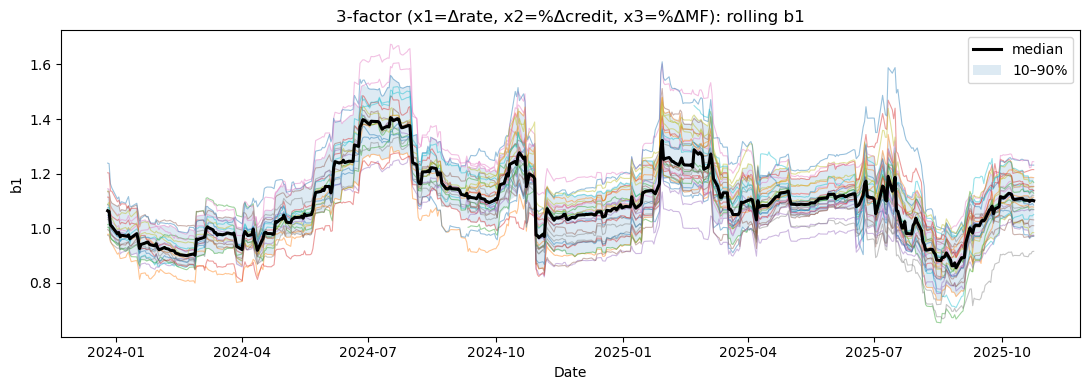

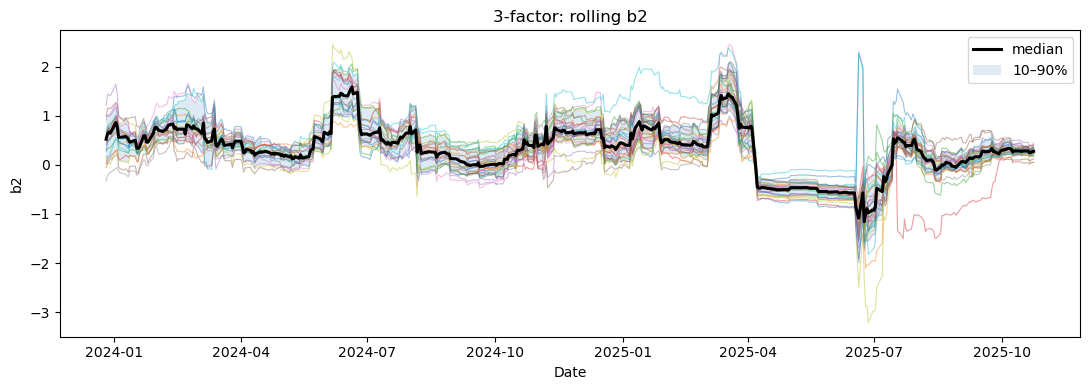

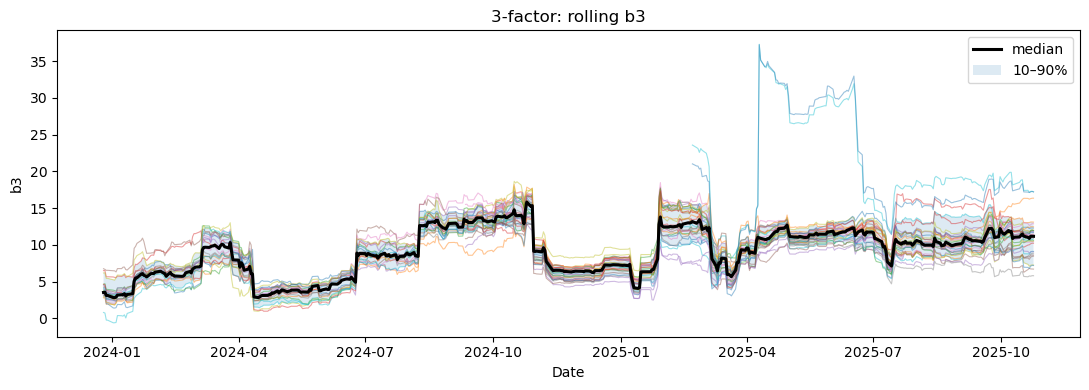

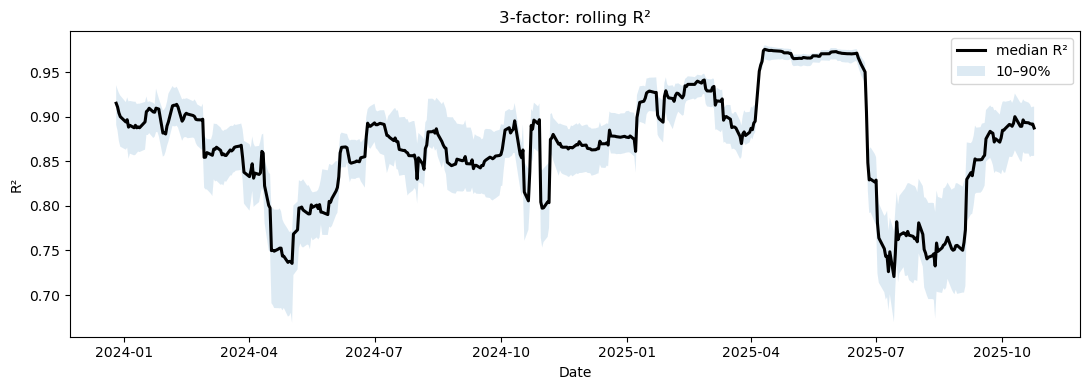

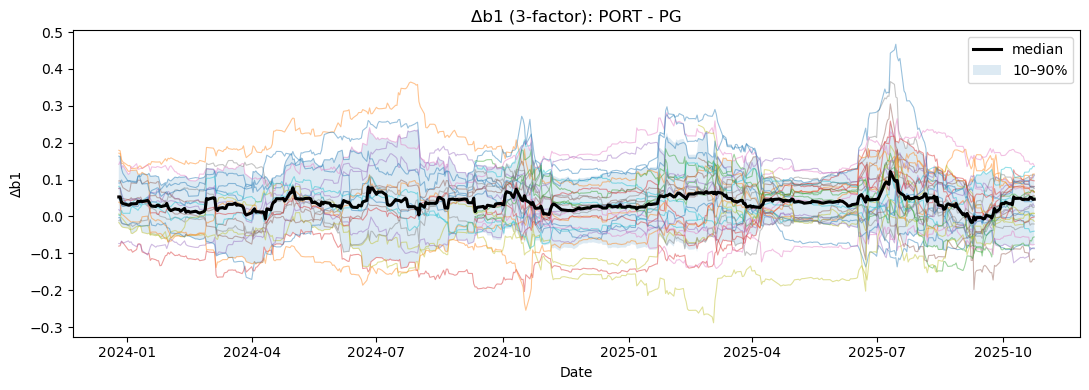

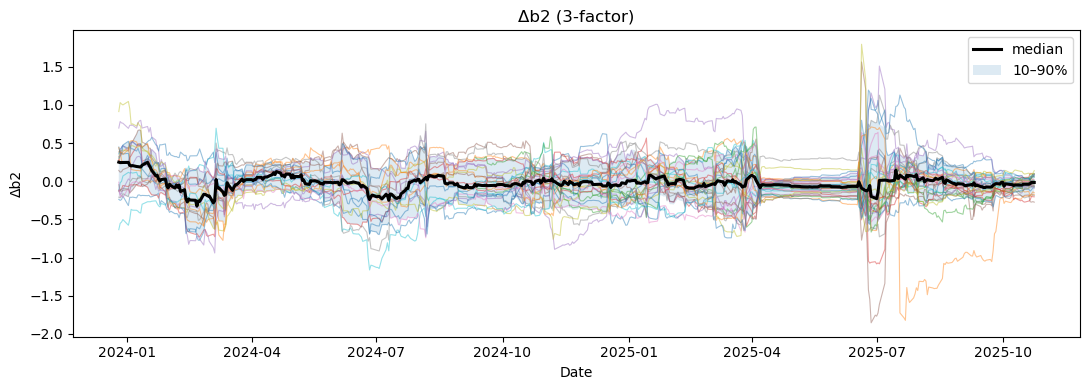

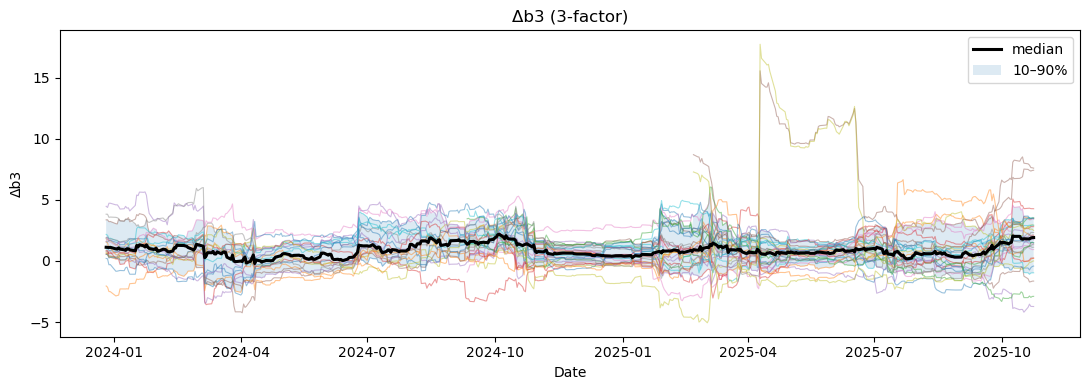

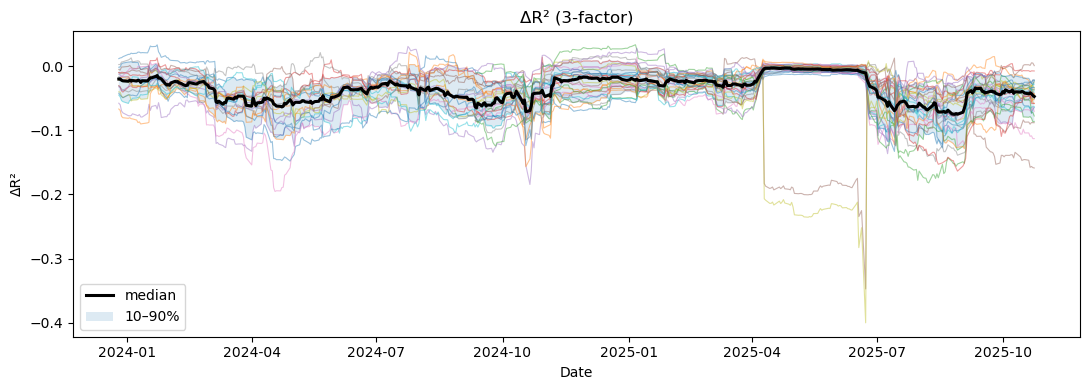

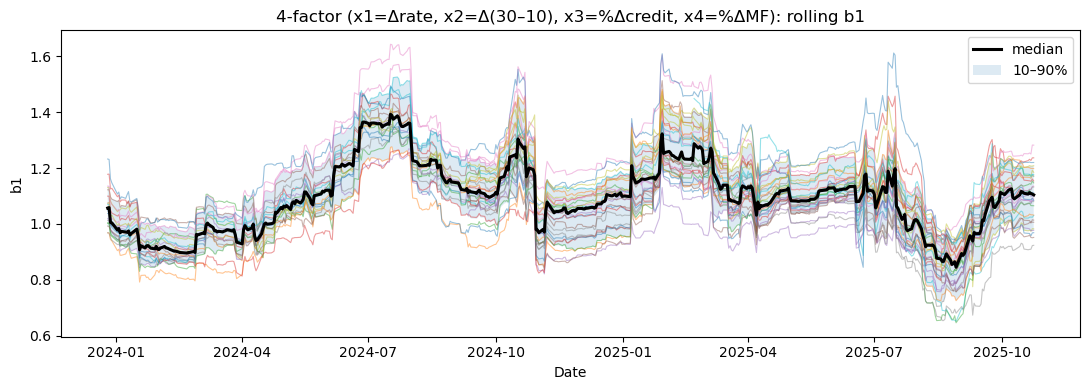

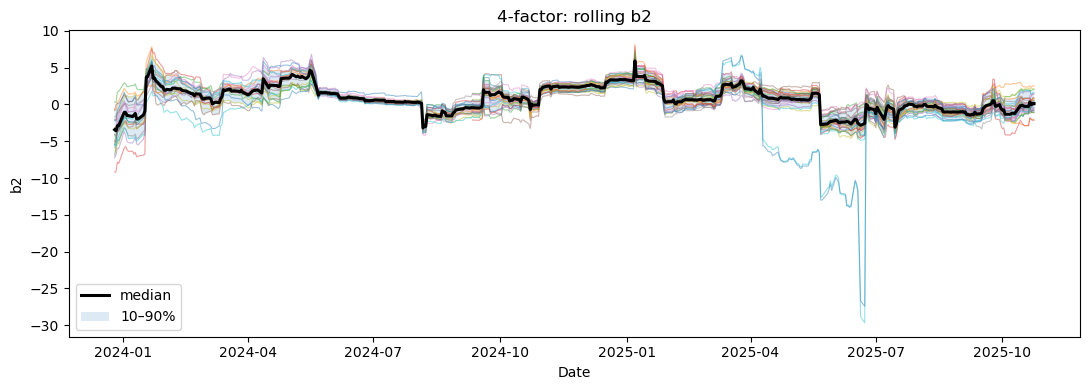

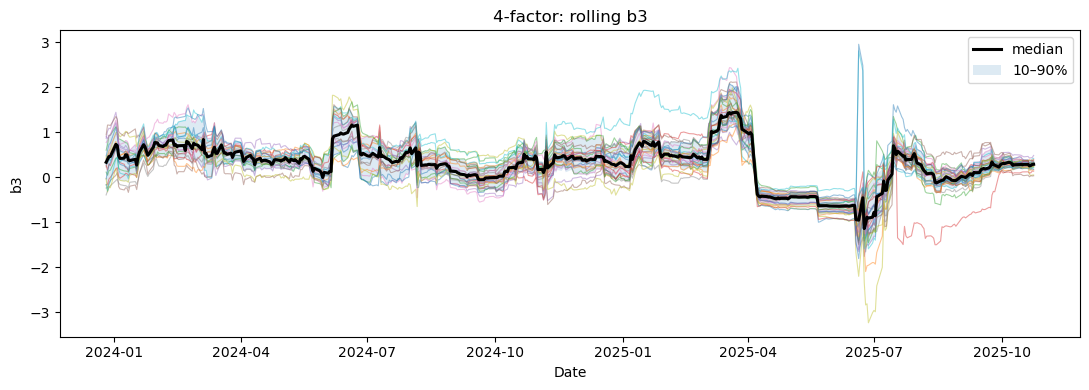

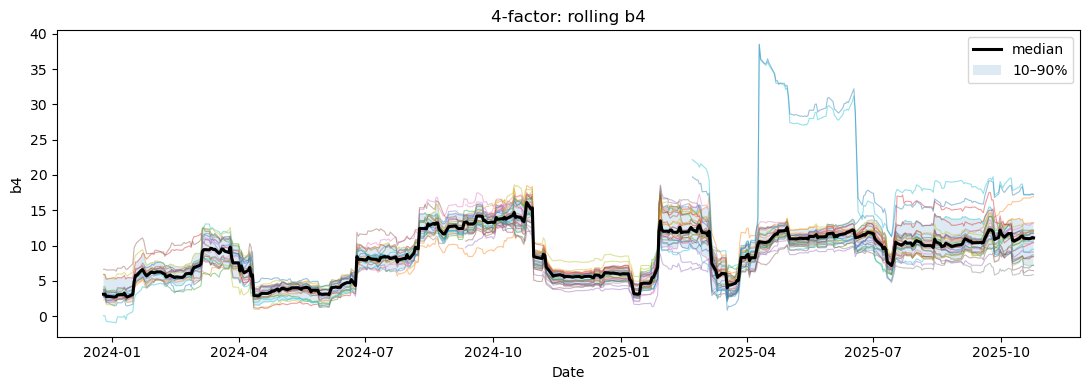

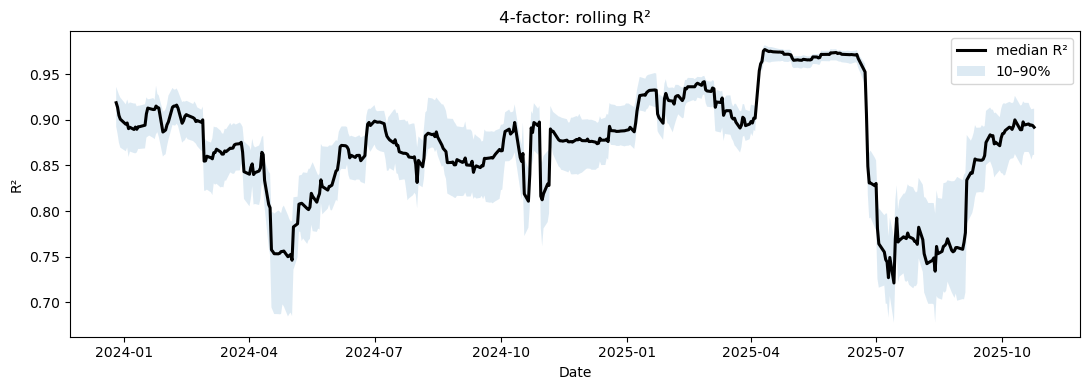

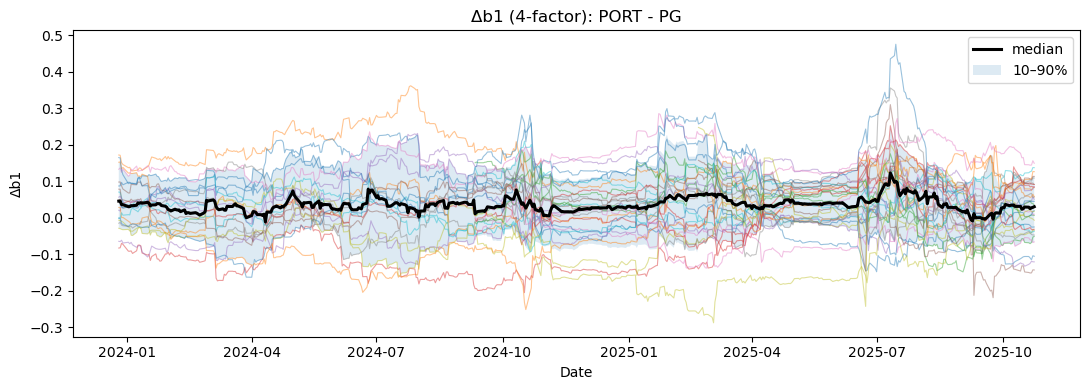

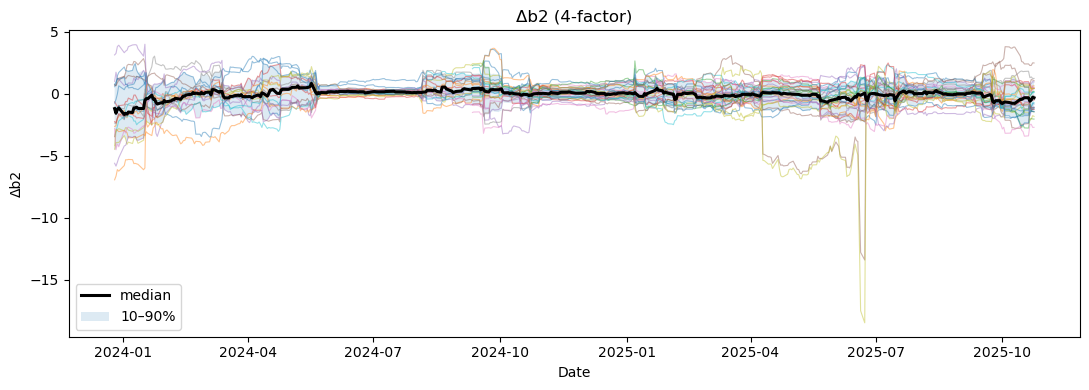

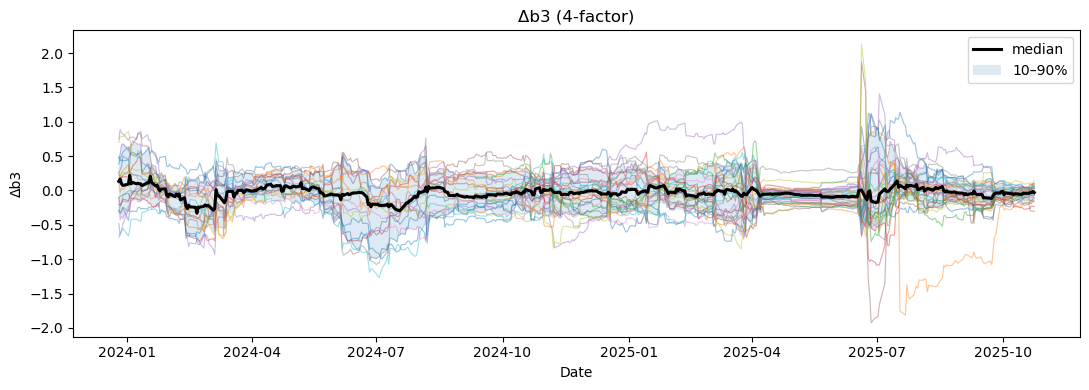

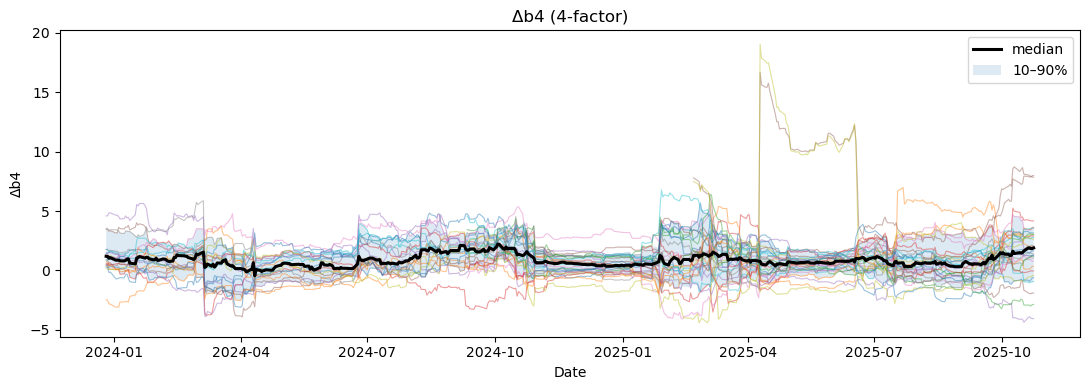

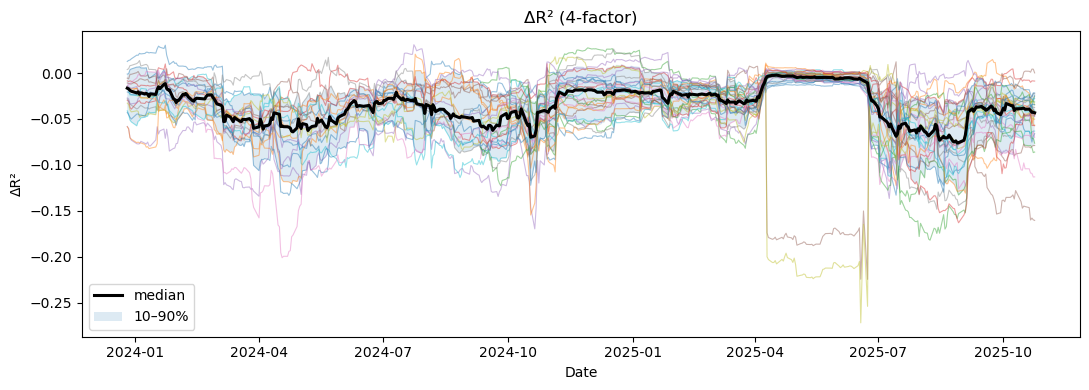

In [ ]:
# ------------------- Plots -------------------
# 3-factor
spec = "3F_MIX_PORT"
pan = rolling_panels[spec]

wide_b1 = wide_from_panels(pan, "b1")
wide_b2 = wide_from_panels(pan, "b2")
wide_b3 = wide_from_panels(pan, "b3")
wide_r2 = wide_from_panels(pan, "r2")

plot_many_lines(wide_b1, f"3-factor (x1=Δrate, x2=%Δcredit, x3=%ΔMF): rolling b1", ylabel="b1")
plot_many_lines(wide_b2, f"3-factor: rolling b2", ylabel="b2")
plot_many_lines(wide_b3, f"3-factor: rolling b3", ylabel="b3")
plot_stability_r2(wide_r2, f"3-factor: rolling R²")

# Rolling std dev of betas
# plot_many_lines(rolling_std(wide_b1), f"{spec}: rolling σ(b1)", ylabel="std(b1)")
# plot_many_lines(rolling_std(wide_b2), f"{spec}: rolling σ(b2)", ylabel="std(b2)")
# plot_many_lines(rolling_std(wide_b3), f"{spec}: rolling σ(b3)", ylabel="std(b3)")

# Delta betas: PORT minus PG
delta_3f = make_delta_panels(rolling_panels["3F_MIX_PORT"], rolling_panels["3F_MIX_PG"], k=3)

# Wide delta matrices
wide_db1_3f = wide_from_delta_panels(delta_3f, "db1")
wide_db2_3f = wide_from_delta_panels(delta_3f, "db2")
wide_db3_3f = wide_from_delta_panels(delta_3f, "db3")
wide_dr2_3f = wide_from_delta_panels(delta_3f, "dr2")

# -------- Delta beta plots: (PORT - PG) --------
plot_many_lines(wide_db1_3f, "Δb1 (3-factor): PORT - PG", ylabel="Δb1")
plot_many_lines(wide_db2_3f, "Δb2 (3-factor)", ylabel="Δb2")
plot_many_lines(wide_db3_3f, "Δb3 (3-factor)", ylabel="Δb3")
plot_many_lines(wide_dr2_3f, "ΔR² (3-factor)", ylabel="ΔR²", show_median=True, band=True)


# 4-factor
spec4 = "4F_MIX_PORT"
pan4 = rolling_panels[spec4]

wide_b1_4 = wide_from_panels(pan4, "b1")
wide_b2_4 = wide_from_panels(pan4, "b2")
wide_b3_4 = wide_from_panels(pan4, "b3")
wide_b4_4 = wide_from_panels(pan4, "b4")
wide_r2_4 = wide_from_panels(pan4, "r2")

plot_many_lines(wide_b1_4, f"4-factor (x1=Δrate, x2=Δ(30–10), x3=%Δcredit, x4=%ΔMF): rolling b1", ylabel="b1")
plot_many_lines(wide_b2_4, f"4-factor: rolling b2", ylabel="b2")
plot_many_lines(wide_b3_4, f"4-factor: rolling b3", ylabel="b3")
plot_many_lines(wide_b4_4, f"4-factor: rolling b4", ylabel="b4")
plot_stability_r2(wide_r2_4, f"4-factor: rolling R²")

# Delta betas: PORT minus PG
delta_4f = make_delta_panels(rolling_panels["4F_MIX_PORT"], rolling_panels["4F_MIX_PG"], k=4)

wide_db1_4f = wide_from_delta_panels(delta_4f, "db1")
wide_db2_4f = wide_from_delta_panels(delta_4f, "db2")
wide_db3_4f = wide_from_delta_panels(delta_4f, "db3")
wide_db4_4f = wide_from_delta_panels(delta_4f, "db4")
wide_dr2_4f = wide_from_delta_panels(delta_4f, "dr2")

# -------- Delta beta plots: (PORT - PG) --------
plot_many_lines(wide_db1_4f, "Δb1 (4-factor): PORT - PG", ylabel="Δb1")
plot_many_lines(wide_db2_4f, "Δb2 (4-factor)", ylabel="Δb2")
plot_many_lines(wide_db3_4f, "Δb3 (4-factor)", ylabel="Δb3")
plot_many_lines(wide_db4_4f, "Δb4 (4-factor)", ylabel="Δb4")
plot_many_lines(wide_dr2_4f, "ΔR² (4-factor)", ylabel="ΔR²", show_median=True, band=True)
